In [1]:
# Libraries
from bs4 import BeautifulSoup, Comment
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
import urllib
import urllib2
import os
import re
import scipy.stats as stats
import unicodedata
import datetime
from datetime import date
from time import strptime
import requests
import requests_cache
requests_cache.install_cache('demo_cache')
%matplotlib inline

In [2]:
link = 'https://www.basketball-reference.com/leagues/NBA_2017_transactions.html'
#link = 'https://www.basketball-reference.com/boxscores/198310280NJN.html'
page = urllib.urlopen(link).read()
soup = BeautifulSoup(page, "lxml")

## Trades

In [3]:
trade_lst = soup.find('div', {'id': 'content'})
lis = trade_lst.find_all('li')

In [4]:
lis[4].span.text

u'July 9, 2016'

In [5]:
transactions = []
dates = []
for li in lis:
    ps = li.find_all('p')
    for p in ps:
        transactions.append(p)
        
        date = li.span.text
        d = date.split(' ')
        month = strptime(d[0][:3],'%b').tm_mon
        dt = datetime.date(int(d[2]), int(month), int(d[1][:-1]))
        
        dates.append(dt)
        #transactions.append((li.span.text, p))

In [6]:
transactions[0]

<p>The <a data-attr-to="PHI" href="/teams/PHI/2017.html">Philadelphia 76ers</a> signed <a href="/players/s/simmobe01.html">Ben Simmons</a> to a multi-year contract.</p>

In [7]:
from time import strptime

month = strptime('Jul','%b').tm_mon

In [8]:
month

7

In [9]:
print len(transactions)
transactions[0]

1782


<p>The <a data-attr-to="PHI" href="/teams/PHI/2017.html">Philadelphia 76ers</a> signed <a href="/players/s/simmobe01.html">Ben Simmons</a> to a multi-year contract.</p>

In [10]:
trades = [(date, trans) for date, trans in zip(dates, transactions) if 'trade' in trans.text]

In [11]:
len(trades)

61

In [12]:
trades[27]

(datetime.date(2017, 2, 20),
 <p>The <a data-attr-from="SAC" href="/teams/SAC/2017.html">Sacramento Kings</a> traded <a href="/players/c/casspom01.html">Omri Casspi</a> and <a href="/players/c/couside01.html">DeMarcus Cousins</a> to the <a data-attr-to="NOP" href="/teams/NOP/2017.html">New Orleans Pelicans</a> for <a href="/players/e/evansty01.html">Tyreke Evans</a>, <a href="/players/g/gallola01.html">Langston Galloway</a>, <a href="/players/h/hieldbu01.html">Buddy Hield</a>, a 2017 1st round draft pick (<a href="/players/c/colliza01.html">Zach Collins</a> was later selected) and a 2017 2nd round draft pick (<a href="/players/m/masonfr01.html">Frank Mason</a> was later selected). (2017 1st-rd pick is top-3 protected) (2017 2nd-rd pick going to SAC is PHI's pick)</p>)

In [13]:
trades[27][1].find_all('a')

[<a data-attr-from="SAC" href="/teams/SAC/2017.html">Sacramento Kings</a>,
 <a href="/players/c/casspom01.html">Omri Casspi</a>,
 <a href="/players/c/couside01.html">DeMarcus Cousins</a>,
 <a data-attr-to="NOP" href="/teams/NOP/2017.html">New Orleans Pelicans</a>,
 <a href="/players/e/evansty01.html">Tyreke Evans</a>,
 <a href="/players/g/gallola01.html">Langston Galloway</a>,
 <a href="/players/h/hieldbu01.html">Buddy Hield</a>,
 <a href="/players/c/colliza01.html">Zach Collins</a>,
 <a href="/players/m/masonfr01.html">Frank Mason</a>]

## Compile team stats before and after trade

In [14]:
def timestamp_to_datetime(timestamp):
    return datetime.date(timestamp.year, timestamp.month, timestamp.day)

In [15]:
def fix_dates(df):
    df = df.reset_index()
    datetimes = []
    for timestamp in df['date']:
        datetimes.append(timestamp_to_datetime(timestamp))
    df['datetime'] = datetimes
    return df

In [16]:
yr = 2017
box_df = pd.read_excel('data/box_scores/box_score_' + str(yr) + '.xlsx')

In [17]:
box_df = fix_dates(box_df)

In [18]:
print len(box_df)
box_df.head()

27874


,index,ast,blk,drb,fg,fg3,fg3_pct,fg3a,fg_pct,fga,...,tov_pct,trb_pct,ts_pct,usg_pct,g_num,g_id,team,date,season,datetime
0,0,0,2,3,5,3,0.60,5,0.385,13,...,11.3,11.0,0.512,22.7,1,201610250CLE,NYK,2016-10-25,2017,2016-10-25
1,1,3,0,4,8,1,0.25,4,0.444,18,...,17.5,8.6,0.503,32.1,1,201610250CLE,NYK,2016-10-25,2017,2016-10-25
2,2,1,1,1,7,1,0.50,2,0.412,17,...,18.3,5.2,0.475,31.2,1,201610250CLE,NYK,2016-10-25,2017,2016-10-25
3,3,0,1,2,0,0,0.00,2,0.000,5,...,28.6,7.9,0.000,15.1,1,201610250CLE,NYK,2016-10-25,2017,2016-10-25
4,4,3,0,5,0,0,NaN,0,0.000,1,...,50.0,15.9,0.000,4.3,1,201610250CLE,NYK,2016-10-25,2017,2016-10-25


In [19]:
team = 'NOP'
team_df = box_df[box_df['team'] == team]

In [20]:
print len(team_df)
team_df.head()

822


,index,ast,blk,drb,fg,fg3,fg3_pct,fg3a,fg_pct,fga,...,tov_pct,trb_pct,ts_pct,usg_pct,g_num,g_id,team,date,season,datetime
189,0,5,4,14,17,0,0.000,2,0.500,34,...,6.7,19.2,0.603,45.2,1,201610260NOP,NOP,2016-10-26,2017,2016-10-26
190,1,11,0,5,6,1,0.333,3,0.600,10,...,7.8,7.2,0.638,14.6,1,201610260NOP,NOP,2016-10-26,2017,2016-10-26
191,2,4,1,1,3,2,0.500,4,0.375,8,...,18.4,1.9,0.563,16.2,1,201610260NOP,NOP,2016-10-26,2017,2016-10-26
192,3,1,0,1,1,0,0.000,4,0.143,7,...,22.2,2.0,0.143,14.0,1,201610260NOP,NOP,2016-10-26,2017,2016-10-26
193,4,1,0,1,1,0,NaN,0,0.333,3,...,0.0,3.2,0.333,7.6,1,201610260NOP,NOP,2016-10-26,2017,2016-10-26


In [21]:
type(team_df['datetime'].iloc[0])

datetime.date

In [22]:
trade_date = datetime.date(2017, 2, 23)

In [23]:
box_before = team_df[team_df['datetime'] < trade_date]
box_after = team_df[team_df['datetime'] > trade_date]

In [24]:
print len(box_before), len(box_after)
box_before.head()

579 233


,index,ast,blk,drb,fg,fg3,fg3_pct,fg3a,fg_pct,fga,...,tov_pct,trb_pct,ts_pct,usg_pct,g_num,g_id,team,date,season,datetime
189,0,5,4,14,17,0,0.000,2,0.500,34,...,6.7,19.2,0.603,45.2,1,201610260NOP,NOP,2016-10-26,2017,2016-10-26
190,1,11,0,5,6,1,0.333,3,0.600,10,...,7.8,7.2,0.638,14.6,1,201610260NOP,NOP,2016-10-26,2017,2016-10-26
191,2,4,1,1,3,2,0.500,4,0.375,8,...,18.4,1.9,0.563,16.2,1,201610260NOP,NOP,2016-10-26,2017,2016-10-26
192,3,1,0,1,1,0,0.000,4,0.143,7,...,22.2,2.0,0.143,14.0,1,201610260NOP,NOP,2016-10-26,2017,2016-10-26
193,4,1,0,1,1,0,NaN,0,0.333,3,...,0.0,3.2,0.333,7.6,1,201610260NOP,NOP,2016-10-26,2017,2016-10-26


In [25]:
np.unique(box_before['id'])

array([u'ajincal01', u'asikom01', u'brownan02', u'cunnida01', u'davisan02',
       u'diallch01', u'evansty01', u'fraziti01', u'gallola01',
       u'goodwar01', u'hieldbu01', u'hillso01', u'holidjr01', u'joneste01',
       u'mooreet01', u'motiedo01', u'stephla01', u'willire02'], dtype=object)

In [26]:
player = 'casspom01'
player_df = box_before[box_before['id'] == player]

In [27]:
print len(player_df)
player_df.head()

0


,index,ast,blk,drb,fg,fg3,fg3_pct,fg3a,fg_pct,fga,...,tov_pct,trb_pct,ts_pct,usg_pct,g_num,g_id,team,date,season,datetime


In [28]:
sum(player_df['fga']), sum(player_df['fta']), sum(player_df['tov']), sum(player_df['sec'])/float(60), 

(0, 0, 0, 0.0)

In [29]:
def get_stats(box_df):
    stats = pd.DataFrame()
    for player in np.unique(box_df['id']):
        player_df = box_df[box_df['id'] == player]
        stats = stats.append({
                'id': player,
                'fga': sum(player_df['fga']),
                'fta': sum(player_df['fta']),
                'tov': sum(player_df['tov']),
                'mp': sum(player_df['sec'])/float(60)
            }, ignore_index = True)
    return stats

In [30]:
before_stats = get_stats(box_before)
after_stats = get_stats(box_after)

In [31]:
before_stats.head()

,fga,fta,id,mp,tov
0,97.0,24.0,ajincal01,350.150000,21.0
1,65.0,39.0,asikom01,482.116667,14.0
2,41.0,0.0,brownan02,142.533333,5.0
3,237.0,14.0,cunnida01,1056.166667,19.0
4,1068.0,458.0,davisan02,1926.816667,139.0


In [32]:
after_stats.head()

,fga,fta,id,mp,tov
0,81.0,16.0,ajincal01,234.116667,10.0
1,41.0,3.0,cookqu01,110.550000,5.0
2,295.0,116.0,couside01,539.566667,61.0
3,218.0,26.0,crawfjo02,442.266667,25.0
4,119.0,13.0,cunnida01,567.200000,8.0


In [33]:
# Function for calculating usage rate for a team
# team_df: a dataframe of a single team's season statistics
def calculate_weighted_off_usg(team_df):
    # Multiply by MP to weight Gini, essentially MP in numerator and denominator cancel
    weighted_off = [mp * (100 * ((fga + 0.44*fta + tov)) * (float(sum(team_df['mp']))/5)) / 
                (mp * (sum(team_df['fga']) + 0.44*sum(team_df['fta']) + sum(team_df['tov'])))
    for fga, fta, tov, mp in zip(team_df['fga'], team_df['fta'], team_df['tov'], team_df['mp'])]
    return weighted_off

In [34]:
# Function for calculating usage rate for a team
# team_df: a dataframe of a single team's season statistics
def calculate_weighted_off_usg_2(team_df):
    # Multiply by MP to weight Gini, essentially MP in numerator and denominator cancel
    weighted_off = [(100 * ((fga + 0.44*fta + tov))) / 
                ((sum(team_df['fga']) + 0.44*sum(team_df['fta']) + sum(team_df['tov'])))
    for fga, fta, tov, mp in zip(team_df['fga'], team_df['fta'], team_df['tov'], team_df['mp'])]
    return weighted_off

In [35]:
def calculate_weighted_def_usg(team_df):
    weighted_def = [mp * 20 for mp in team_df['mp']]
    return weighted_def

In [36]:
def calculate_weighted_def_usg_2(team_df):
    weighted_def = [float(mp)/(sum(team_df['mp'])/5) * 20 for mp in team_df['mp']]
    return weighted_def

In [37]:
def calculate_weighted_usg(team_df):
    off_usg = calculate_weighted_off_usg(team_df)
    def_usg = calculate_weighted_def_usg(team_df)
    weighted_usg = [(o_usg + d_usg)/2 for o_usg, d_usg in zip(off_usg, def_usg)]
    #return weighted_usg
    return zip(team_df['id'], weighted_usg)

In [38]:
def calculate_weighted_usg_2(team_df):
    off_usg = calculate_weighted_off_usg_2(team_df)
    def_usg = calculate_weighted_def_usg_2(team_df)
    weighted_usg = [(o_usg + d_usg)/2 for o_usg, d_usg in zip(off_usg, def_usg)]
    return zip(team_df['id'], [w/100 for w in weighted_usg])

In [39]:
# Take weighted usage rates, normalize them (sum = 1), sort them
def get_norm_usg(w_usg):
    return sorted([u/sum(w_usg) for u in w_usg])

In [40]:
# Subset only the top k usages, renormalize them
def get_norm_top_k(n_usg, k):
    new_usg = n_usg[-k:]
    return get_norm_usg(new_usg)

In [41]:
before_usg = calculate_weighted_usg(before_stats)
after_usg = calculate_weighted_usg(after_stats)

In [42]:
before_usg_lst = calculate_weighted_usg_2(before_stats)
after_usg_lst = calculate_weighted_usg_2(after_stats)

In [43]:
after_usg_lst

[(u'ajincal01', 0.03885776972156228),
 (u'cookqu01', 0.018544359713784063),
 (u'couside01', 0.12411448433583455),
 (u'crawfjo02', 0.08661848039620747),
 (u'cunnida01', 0.07414060332970655),
 (u'davisan02', 0.16974641120374115),
 (u'diallch01', 0.017949317253528937),
 (u'fraziti01', 0.06694057008235915),
 (u'hillso01', 0.10806490986834955),
 (u'holidjr01', 0.14302364821668198),
 (u'jackja01', 0.004160075339961349),
 (u'mooreet01', 0.08346324107813403),
 (u'motiedo01', 0.026575961480971615),
 (u'seldewa01', 0.006476998711133958),
 (u'thompho01', 0.024285618347562883),
 (u'toupaax01', 0.005089532924860905),
 (u'willire02', 0.0019480179956196078)]

In [44]:
after_usg_dict = {k:v for k, v in after_usg_lst}
before_usg_dict = {k:v for k, v in before_usg_lst}

In [45]:
before_usg_dict['davisan02']

0.18298523147909507

In [46]:
sum([b for a,b in after_usg])

116200.99999999999

In [47]:
after_usg

[(u'ajincal01', 4515.311699415258),
 (u'cookqu01', 2154.873143101421),
 (u'couside01', 14422.227194308307),
 (u'crawfjo02', 10065.154040519701),
 (u'cunnida01', 8615.212247515228),
 (u'davisan02', 19724.702728285927),
 (u'diallch01', 2085.7286141773156),
 (u'fraziti01', 7778.561184140215),
 (u'hillso01', 12557.250591612084),
 (u'holidjr01', 16619.49094642666),
 (u'jackja01', 483.40491457884855),
 (u'mooreet01', 9698.512076520252),
 (u'motiedo01', 3088.153300050382),
 (u'seldewa01', 752.6337272324768),
 (u'thompho01', 2822.013137605154),
 (u'toupaax01', 591.4088154017618),
 (u'willire02', 226.36163910899398)]

In [48]:
before_usg = [usg for player, usg in before_usg_lst]
after_usg = [usg for player, usg in after_usg_lst]
n_before_usg = get_norm_usg(before_usg)
n_after_usg = get_norm_usg(after_usg)

In [49]:
len(n_before_usg), len(n_after_usg)

(18, 17)

In [50]:
zip(n_before_usg, n_after_usg)

[(0.0018301377979854196, 0.0019480179956196078),
 (0.00414936426540977, 0.004160075339961349),
 (0.007047227517608848, 0.005089532924860905),
 (0.008848805954493015, 0.006476998711133958),
 (0.011461398977792723, 0.017949317253528937),
 (0.020642392262892825, 0.018544359713784063),
 (0.022991083452817734, 0.024285618347562883),
 (0.025143725050530776, 0.026575961480971615),
 (0.04057192989400689, 0.03885776972156228),
 (0.05923045585438583, 0.06694057008235915),
 (0.0707152683754044, 0.07414060332970655),
 (0.08002934691049013, 0.08346324107813403),
 (0.08488213390172364, 0.08661848039620747),
 (0.08667465270189412, 0.10806490986834955),
 (0.08834426877349594, 0.12411448433583455),
 (0.09490131243605128, 0.14302364821668198),
 (0.10955126439392167, 0.16974641120374115)]

In [51]:
n_before_usg_k = get_norm_top_k(n_before_usg, 9)
n_after_usg_k = get_norm_top_k(n_after_usg, 9)

In [52]:
zip(n_before_usg_k, n_after_usg_k)

[(0.06908840909762569, 0.04341795209688138),
 (0.08248468326800103, 0.07479643031496526),
 (0.09334893982178151, 0.08284142880225143),
 (0.09900939487109295, 0.09325813161556792),
 (0.10110024948963281, 0.09678365638314847),
 (0.10304774620440367, 0.12074694748664962),
 (0.11069610393683994, 0.13868003166512516),
 (0.12778430390974233, 0.15980829449270426),
 (0.21344016940088004, 0.18966712714270642)]

In [53]:
x = range(len(n_before_usg_k)+1)
y1_before = np.cumsum([0] + n_before_usg_k)
y2 = [float(t)/(len(x)-1) for t in x]
gini_before = 2*(np.trapz(y2) - np.trapz(y1_before))/(x[-1]*y1_before[-1]) * len(n_before_usg_k)/(len(n_before_usg_k)-1)

y1_after = np.cumsum([0] + n_after_usg_k)
gini_after = 2*(np.trapz(y2) - np.trapz(y1_after))/(x[-1]*y1_after[-1]) * len(n_before_usg_k)/(len(n_before_usg_k)-1)

In [54]:
def get_gini(n_usg_k):
    x = range(len(n_usg_k)+1)
    y1 = np.cumsum([0] + n_usg_k)
    y2 = [float(t)/(len(x)-1) for t in x]
    gini = 2*(np.trapz(y2) - np.trapz(y1))/(x[-1]*y1[-1]) * len(n_usg_k)/(len(n_usg_k)-1)
    return gini

In [55]:
get_gini(n_after_usg_k)

0.24479957857833684

In [56]:
gini_before, gini_after

(0.18800964567541734, 0.24479957857833684)

In [57]:
player1 = 'hieldbu01'
before_usg_dict[player1]

0.08488213390172362

In [58]:
player2 = 'couside01'
after_usg_dict[player2]

0.12411448433583455

In [59]:
def get_trade_info(team1, player1, trade_date, yr):
    box_df = pd.read_excel('data/box_scores/box_score_' + str(yr) + '.xlsx')
    box_df = fix_dates(box_df)
    team_df = box_df[box_df['team'] == team1]
    box_before = team_df[team_df['datetime'] < trade_date]
    box_after = team_df[team_df['datetime'] > trade_date]
    before_stats = get_stats(box_before)
    after_stats = get_stats(box_after)
    before_usg_lst = calculate_weighted_usg_2(before_stats)
    after_usg_lst = calculate_weighted_usg_2(after_stats)
    after_usg_dict = {k:v for k, v in after_usg_lst}
    before_usg_dict = {k:v for k, v in before_usg_lst}
    before_usg = [usg for player, usg in before_usg_lst]
    after_usg = [usg for player, usg in after_usg_lst]
    n_before_usg = get_norm_usg(before_usg)
    n_after_usg = get_norm_usg(after_usg)
    n_before_usg_k = get_norm_top_k(n_before_usg, 9)
    n_after_usg_k = get_norm_top_k(n_after_usg, 9)
    gini_before = get_gini(n_before_usg_k)
    gini_after = get_gini(n_after_usg_k)
    player_usg_before = before_usg_dict[player1]
    return gini_before, gini_after, player_usg_before

In [60]:
get_trade_info('NOP', 'hieldbu01', datetime.date(2017, 2, 20), 2017)

(0.18800964567541734, 0.24975579022160771, 0.08488213390172362)

In [61]:
date = datetime.date(2017, 2, 20)
get_trade_info('SAC', 'couside01', date, date.year)

(0.20438688360197754, 0.17451419517187738, 0.1969676407091681)

In [62]:
for trade in trades:
    if len(trade[1].find_all('a')) == 4:
        print trade[0], trade[1].find_all('a')

2016-07-07 [<a data-attr-from="CHO" href="/teams/CHO/2017.html">Charlotte Hornets</a>, <a href="/players/r/richama01.html">Malachi Richardson</a>, <a data-attr-to="SAC" href="/teams/SAC/2017.html">Sacramento Kings</a>, <a href="/players/b/belinma01.html">Marco Belinelli</a>]
2016-07-07 [<a data-attr-from="IND" href="/teams/IND/2017.html">Indiana Pacers</a>, <a href="/players/l/leverca01.html">Caris LeVert</a>, <a data-attr-to="BRK" href="/teams/BRK/2017.html">Brooklyn Nets</a>, <a href="/players/y/youngth01.html">Thaddeus Young</a>]
2016-07-07 [<a data-attr-from="CHI" href="/teams/CHI/2017.html">Chicago Bulls</a>, <a href="/players/c/caldejo01.html">Jose Calderon</a>, <a data-attr-to="LAL" href="/teams/LAL/2017.html">Los Angeles Lakers</a>, <a href="/players/m/majokat01.html">Ater Majok</a>]
2016-07-07 [<a data-attr-from="CLE" href="/teams/CLE/2017.html">Cleveland Cavaliers</a>, <a href="/players/d/dellama01.html">Matthew Dellavedova</a>, <a data-attr-to="MIL" href="/teams/MIL/2017.htm

## Free agent signings

In [63]:
#transactions

In [64]:
signings = [(date, trans) for date, trans in zip(dates, transactions) if (('signed' in trans.text) & ('assigned' not in trans.text))]

In [65]:
signings

[(datetime.date(2016, 7, 2),
  <p>The <a data-attr-to="PHI" href="/teams/PHI/2017.html">Philadelphia 76ers</a> signed <a href="/players/s/simmobe01.html">Ben Simmons</a> to a multi-year contract.</p>),
 (datetime.date(2016, 7, 2),
  <p>The <a data-attr-to="PHI" href="/teams/PHI/2017.html">Philadelphia 76ers</a> signed <a href="/players/l/luwawti01.html">Timothe Luwawu-Cabarrot</a> to a multi-year contract.</p>),
 (datetime.date(2016, 7, 7),
  <p>The <a data-attr-to="DAL" href="/teams/DAL/2017.html">Dallas Mavericks</a> signed <a href="/players/b/barneha02.html">Harrison Barnes</a> to a multi-year contract.</p>),
 (datetime.date(2016, 7, 7),
  <p>The <a data-attr-to="POR" href="/teams/POR/2017.html">Portland Trail Blazers</a> signed <a href="/players/l/laymaja01.html">Jake Layman</a> to a multi-year contract.</p>),
 (datetime.date(2016, 7, 7),
  <p>The <a data-attr-to="CHO" href="/teams/CHO/2017.html">Charlotte Hornets</a> signed <a href="/players/b/batumni01.html">Nicolas Batum</a> to 

In [66]:
len(signings)

477

In [67]:
len(trades)

61

In [70]:
sign = signings[38]
sign

(datetime.date(2016, 7, 8),
 <p>The <a data-attr-to="BOS" href="/teams/BOS/2017.html">Boston Celtics</a> signed <a href="/players/h/horfoal01.html">Al Horford</a> to a multi-year contract.</p>)

In [71]:
link_tail = sign[1].find_all('a')[1]['href']

In [72]:
player_link = 'https://www.basketball-reference.com' + link_tail
player_link

'https://www.basketball-reference.com/players/h/horfoal01.html'

In [73]:
sign[0]

datetime.date(2016, 7, 8)

In [74]:
sign[1]

<p>The <a data-attr-to="BOS" href="/teams/BOS/2017.html">Boston Celtics</a> signed <a href="/players/h/horfoal01.html">Al Horford</a> to a multi-year contract.</p>

In [75]:
sign[1].find_all('a')[0]['href'][7:10]

'BOS'

In [76]:
sign[1].find_all('a')[0]['data-attr-to']

'BOS'

In [77]:
def calculate_weighted_usg_3(team_df):
    off_usg = calculate_weighted_off_usg_2(team_df)
    def_usg = calculate_weighted_def_usg_2(team_df)
    weighted_usg = [(o_usg + d_usg)/2 for o_usg, d_usg in zip(off_usg, def_usg)]
    return [w/100 for w in weighted_usg]

In [157]:
def get_gini_season(yr, team, k):
    season_df = pd.read_excel('data/season_data/season_data_' + str(yr) + '.xlsx')
    season_df = season_df[season_df['mp'] != 0]
    
    team_df = season_df[season_df['team'] == team]
    usg = calculate_weighted_usg_3(team_df)
    n_usg = get_norm_usg(usg)
    n_usg_k = get_norm_top_k(n_usg, k=k)
    x = range(len(n_usg_k)+1)
    y1 = np.cumsum([0] + n_usg_k)
    y2 = [float(t)/(len(x)-1) for t in x]
    gini = 2*(np.trapz(y2) - np.trapz(y1))/(x[-1]*y1[-1]) * len(n_usg_k)/(len(n_usg_k)-1)
    return gini

In [159]:
get_gini_season(2017, 'CHH', 9)

0.23040440543985585

In [154]:
get_gini_season(2016, 'GSW', 9)

0.2921595401144288

In [81]:
team = sign[1].find_all('a')[0]['href'][7:10]
year = sign[0].year

In [82]:
get_gini_season(year+1, team, 9)

0.21147604073687362

In [83]:
get_gini_season(year, team, 9)

0.20538792126501004

In [84]:
team = 'OKC'
yr = 2016
player = 'duranke01'

box_df = pd.read_excel('data/box_scores/box_score_' + str(yr) + '.xlsx')
box_df = fix_dates(box_df)
team_df = box_df[box_df['team'] == team]

stats = get_stats(team_df)
usg_lst = calculate_weighted_usg_2(stats)
usg_dict = {k:v for k, v in usg_lst}
player_usg_prev_season = usg_dict[player]

In [88]:
[usg[1] for usg in usg_lst]

[0.0867914649509886,
 0.018123030519989137,
 0.02417244798662077,
 0.17452743663075151,
 0.026566346196952483,
 0.0022287720714594395,
 0.11810135907581831,
 0.09120806957316394,
 0.0030303672935553727,
 0.0011322565457606989,
 0.03853054642403146,
 0.00108476202826278,
 0.03215623813519681,
 0.06142467894010001,
 0.03383042961905191,
 0.10187281407367092,
 0.18521897993462585]

In [89]:
player_usg_prev_season

0.17452743663075151

In [91]:
# Get new team's gini the season before and after the signing
sign = signings[38]
new_team = sign[1].find_all('a')[0]['data-attr-to']
yr = sign[0].year

gini_df = pd.read_excel('data/nba_results_gini_new.xlsx')
before_gini_new = gini_df[(gini_df['abbr'] == new_team) & (gini_df['yr'] == yr)]['gini'].values[0]
after_gini_new = gini_df[(gini_df['abbr'] == new_team) & (gini_df['yr'] == yr+1)]['gini'].values[0]
print new_team, before_gini_new, after_gini_new

BOS 0.205387921265 0.211476040737


In [92]:
link_tail = sign[1].find_all('a')[1]['href']
player_link = 'https://www.basketball-reference.com' + link_tail
page = urllib.urlopen(player_link).read()
soup = BeautifulSoup(page, "lxml")
id_name = 'per_game.' + str(year)
row = soup.find('tr', {'id': id_name})
tds = row.find_all('td')
old_team = tds[1].text
before_gini_old = gini_df[(gini_df['abbr'] == old_team) & (gini_df['yr'] == yr)]['gini'].values[0]
after_gini_old = gini_df[(gini_df['abbr'] == old_team) & (gini_df['yr'] == yr+1)]['gini'].values[0]
print old_team, before_gini_old, after_gini_old

ATL 0.226271003285 0.239535101877


In [93]:
url_parts = link_tail.split('/')
player_id = url_parts[3].split('.')[0]

In [94]:
box_df = pd.read_excel('data/box_scores/box_score_' + str(yr) + '.xlsx')
box_df = fix_dates(box_df)
team_df = box_df[box_df['team'] == old_team]

stats = get_stats(team_df)
usg_lst = calculate_weighted_usg_2(stats)
usg_dict = {k:v for k, v in usg_lst}
player_usg_prev_season = usg_dict[player_id]
player_usg_prev_season

0.13467296893982741

In [95]:
print player_id, old_team, before_gini_old, after_gini_old, new_team, before_gini_new, after_gini_new, player_usg_prev_season

horfoal01 ATL 0.226271003285 0.239535101877 BOS 0.205387921265 0.211476040737 0.13467296894


In [96]:
usg_dict

{u'bazemke01': 0.10809705878180395,
 u'hardati02': 0.03874544513921418,
 u'hinriki01': 0.0033829922900630045,
 u'holidju01': 0.010459011824875098,
 u'horfoal01': 0.13467296893982741,
 u'humphkr01': 0.016336589967226697,
 u'korveky01': 0.10265703720478558,
 u'macksh01': 0.009795745619867362,
 u'millspa01': 0.14959378315921645,
 u'muscami01': 0.025294697659054517,
 u'pattela01': 0.01557417695195339,
 u'schrode01': 0.09998913473559867,
 u'scottmi01': 0.05445667383291726,
 u'sefolth01': 0.07159689150730258,
 u'splitti01': 0.023116125077539785,
 u'tavarwa01': 0.0030207251563739734,
 u'teaguje01': 0.13321094215238005}

In [97]:
signing_df = pd.DataFrame()
for i, sign in enumerate(signings):
    link_tail = sign[1].find_all('a')[1]['href']
    url_parts = link_tail.split('/')
    player_id = url_parts[3].split('.')[0]
    signing_df = signing_df.append({
            'date': sign[0],
            'signing': sign[1],
            'team_to': sign[1].find_all('a')[0]['data-attr-to'],
            'player': player_id
        }, ignore_index = True)

In [98]:
signing_df.head()

,date,player,signing,team_to
0,2016-07-02,simmobe01,"<p>The <a data-attr-to=""PHI"" href=""/teams/PHI/...",PHI
1,2016-07-02,luwawti01,"<p>The <a data-attr-to=""PHI"" href=""/teams/PHI/...",PHI
2,2016-07-07,barneha02,"<p>The <a data-attr-to=""DAL"" href=""/teams/DAL/...",DAL
3,2016-07-07,laymaja01,"<p>The <a data-attr-to=""POR"" href=""/teams/POR/...",POR
4,2016-07-07,batumni01,"<p>The <a data-attr-to=""CHO"" href=""/teams/CHO/...",CHO


In [99]:
signings

[(datetime.date(2016, 7, 2),
  <p>The <a data-attr-to="PHI" href="/teams/PHI/2017.html">Philadelphia 76ers</a> signed <a href="/players/s/simmobe01.html">Ben Simmons</a> to a multi-year contract.</p>),
 (datetime.date(2016, 7, 2),
  <p>The <a data-attr-to="PHI" href="/teams/PHI/2017.html">Philadelphia 76ers</a> signed <a href="/players/l/luwawti01.html">Timothe Luwawu-Cabarrot</a> to a multi-year contract.</p>),
 (datetime.date(2016, 7, 7),
  <p>The <a data-attr-to="DAL" href="/teams/DAL/2017.html">Dallas Mavericks</a> signed <a href="/players/b/barneha02.html">Harrison Barnes</a> to a multi-year contract.</p>),
 (datetime.date(2016, 7, 7),
  <p>The <a data-attr-to="POR" href="/teams/POR/2017.html">Portland Trail Blazers</a> signed <a href="/players/l/laymaja01.html">Jake Layman</a> to a multi-year contract.</p>),
 (datetime.date(2016, 7, 7),
  <p>The <a data-attr-to="CHO" href="/teams/CHO/2017.html">Charlotte Hornets</a> signed <a href="/players/b/batumni01.html">Nicolas Batum</a> to 

In [267]:
signings[15]

(datetime.date(2012, 7, 13),
 <p>The <a data-attr-to="IND" href="/teams/IND/2013.html">Indiana Pacers</a> signed <a href="/players/a/augusdj01.html">D.J. Augustin</a> as a free agent.</p>)

In [274]:
# Get new team's gini the season before and after the signing
# Print nothing if no previous team
sign = signings[15]
new_team = sign[1].find_all('a')[0]['data-attr-to']
yr = sign[0].year

link_tail = sign[1].find_all('a')[1]['href']
player_link = 'https://www.basketball-reference.com' + link_tail
page = urllib.urlopen(player_link).read()
soup = BeautifulSoup(page, "lxml")
id_name = 'per_game.' + str(year)

if soup.find('tr', {'id': id_name}) != None:
    row = soup.find_all('tr', {'id': id_name})
    tds = row[-1].find_all('td')
    old_team = tds[1].text

    if (old_team == 'CHO') | (old_team == 'CHA'):
        old_team = 'CHH'
    if old_team == 'TOT':
        print [None] * 9
    
    # Get previous team stats
    old_team = tds[1].text
    print old_team
    before_gini_old = gini_df[(gini_df['abbr'] == old_team) & (gini_df['yr'] == yr)]['gini'].values[0]
    after_gini_old = gini_df[(gini_df['abbr'] == old_team) & (gini_df['yr'] == yr+1)]['gini'].values[0]
    print old_team, before_gini_old, after_gini_old
    
    # Get new team stats
    gini_df = pd.read_excel('data/nba_results_gini_new.xlsx')
    before_gini_new = gini_df[(gini_df['abbr'] == new_team) & (gini_df['yr'] == yr)]['gini'].values[0]
    after_gini_new = gini_df[(gini_df['abbr'] == new_team) & (gini_df['yr'] == yr+1)]['gini'].values[0]
    print new_team, before_gini_new, after_gini_new

    # Get last year's usage for new team
    box_df = pd.read_excel('data/box_scores/box_score_' + str(yr) + '.xlsx')
    box_df = fix_dates(box_df)
    team_df = box_df[box_df['team'] == new_team]
    stats = get_stats(team_df)
    usg_lst = calculate_weighted_usg_2(stats)
    usg = [u[1] for u in usg_lst]
    print usg
    
    # Player's previous usage
    url_parts = link_tail.split('/')
    player_id = url_parts[3].split('.')[0]
    stats = get_stats(team_df)
    usg_lst = calculate_weighted_usg_2(stats)
    usg_dict = {k:v for k, v in usg_lst}
    player_usg_prev_season = usg_dict[player_id]
    print player_id, player_usg_prev_season

DEN
DEN 0.226588273517 0.157318239145
IND 0.206503923955 0.240805681312
[0.042204077063869555, 0.037006991306113776, 0.10465439277986956, 0.000924253810544175, 0.005557126059039972, 0.12162160329149613, 0.15213570423098324, 0.08807103987534319, 0.12507236237642347, 0.08215466144546817, 0.05398230891976752, 0.005785000865067269, 0.029115892253764857, 0.0232379504131249, 0.1284766353091242]


KeyError: 'augusdj01'

In [290]:
def get_signing_info(sign):
    try:
        new_team = sign[1].find_all('a')[0]['data-attr-to']

        #shotty fix
        if (new_team == 'CHO') | (new_team == 'CHA'):
            new_team = 'CHH'

        yr = sign[0].year

        gini_df = pd.read_excel('data/nba_results_gini_new.xlsx')
        before_gini_new = gini_df[(gini_df['abbr'] == new_team) & (gini_df['yr'] == yr)]['gini'].values[0]
        after_gini_new = gini_df[(gini_df['abbr'] == new_team) & (gini_df['yr'] == yr+1)]['gini'].values[0]

        link_tail = sign[1].find_all('a')[1]['href']
        url_parts = link_tail.split('/')
        player_id = url_parts[3].split('.')[0]
        player_link = 'https://www.basketball-reference.com' + link_tail
        page = urllib.urlopen(player_link).read()
        soup = BeautifulSoup(page, "lxml")
        id_name = 'per_game.' + str(yr)

        print player_id

        if soup.find('tr', {'id': id_name}) != None:    
            row = soup.find_all('tr', {'id': id_name})
            tds = row[-1].find_all('td')
            old_team = tds[1].text
            
            #print old_team
            if (old_team == 'CHO') | (old_team == 'CHA'):
                old_team = 'CHH'
            if old_team == 'TOT':
                return [None] * 9
            print old_team

            before_gini_old = gini_df[(gini_df['abbr'] == old_team) & (gini_df['yr'] == yr)]['gini'].values[0]
            after_gini_old = gini_df[(gini_df['abbr'] == old_team) & (gini_df['yr'] == yr+1)]['gini'].values[0]

            box_df = pd.read_excel('data/box_scores/box_score_' + str(yr) + '.xlsx')
            box_df = fix_dates(box_df)
            team_df = box_df[box_df['team'] == old_team]

            stats = get_stats(team_df)
            usg_lst = calculate_weighted_usg_2(stats)
            usg_dict = {k:v for k, v in usg_lst}
            player_usg_prev_season = usg_dict[player_id]

            return [sign[0], player_id, player_usg_prev_season, old_team, before_gini_old, after_gini_old, new_team, before_gini_new, after_gini_new]
        else:
            return [sign[0], player_id] + [None] * 7
    except IndexError:
        return [None] * 9

In [283]:
get_signing_info(signings[15])

augusdj01
CHA
CHH


KeyError: 'fga'

In [285]:
yr = 2013
old_team = 'CHH'
box_df = pd.read_excel('data/box_scores/box_score_' + str(yr) + '.xlsx')
box_df = fix_dates(box_df)
team_df = box_df[box_df['team'] == old_team]

stats = get_stats(team_df)
print stats
usg_lst = calculate_weighted_usg_2(stats)
usg_dict = {k:v for k, v in usg_lst}
player_usg_prev_season = usg_dict[player_id]

       fga    fta         id           mp    tov
0    168.0  100.0  adrieje01   713.066667   32.0
1    346.0  142.0  biyombi01  2186.233333   82.0
2      0.0    0.0  carroma01     5.850000    0.0
3     27.0    1.0   diopde01   226.000000    8.0
4    760.0  127.0  gordobe01  1560.000000  136.0
5    216.0   66.0  haywobr01  1162.100000   50.0
6    855.0  313.0  hendege02  2133.283333  108.0
7     19.0    2.0  higgico01    32.233333    0.0
8    613.0  187.0  kiddgmi01  2024.783333  101.0
9    190.0   55.0  mcrobjo01   802.233333   38.0
10   563.0   99.0  mulleby01  1427.666667   74.0
11   142.0    9.0  pargoja01   292.400000   28.0
12   676.0  347.0  sessira01  1651.550000  104.0
13   399.0  103.0  tayloje03  1507.433333   48.0
14   136.0   31.0  thomaty01   359.950000   17.0
15  1244.0  371.0  walkeke02  2858.700000  200.0
16   163.0   86.0  warriha01   481.683333   29.0
17   132.0   21.0  willire02   379.983333   19.0


KeyError: 'augusdj01'

In [109]:
signings[0][0] < datetime.date(2017,1,1)

True

In [110]:
signings_off_season = [sign for sign in signings if sign[0] < datetime.date(2017,1,1)]

In [111]:
len(signings_off_season)

372

## Run this code to get free agent signings

In [334]:
yr = 2003
link = 'https://www.basketball-reference.com/leagues/NBA_' + str(yr) + '_transactions.html'
#link = 'https://www.basketball-reference.com/boxscores/198310280NJN.html'
page = urllib.urlopen(link).read()
soup = BeautifulSoup(page, "lxml")

trade_lst = soup.find('div', {'id': 'content'})
lis = trade_lst.find_all('li')

transactions = []
dates = []
for li in lis:
    ps = li.find_all('p')
    for p in ps:
        transactions.append(p)
        
        date = li.span.text
        d = date.split(' ')
        month = strptime(d[0][:3],'%b').tm_mon
        dt = datetime.date(int(d[2]), int(month), int(d[1][:-1]))
        
        dates.append(dt)
        #transactions.append((li.span.text, p))
        
signings = [(date, trans) for date, trans in zip(dates, transactions) if (('signed' in trans.text) & ('assigned' not in trans.text))]
signings_offseason = [sign for sign in signings if sign[0] < datetime.date(yr,1,1)]

In [335]:
len(signings_offseason)

104

In [336]:
#del signings_offseason[15]

In [337]:
signing_df = pd.DataFrame()
for i, sign in enumerate(signings_offseason):
    print i
    info = get_signing_info(sign)
    signing_df = signing_df.append({
            'date': info[0],
            'player_id': info[1],
            'usg_prev': info[2],
            'team_prev': info[3],
            'team_prev_gini_before': info[4],
            'team_prev_gini_after': info[5],
            'team_to': info[6],
            'team_to_gini_before': info[7],
            'team_to_gini_after': info[8]
        }, ignore_index = True)
    
signing_df = signing_df.drop_duplicates(['player_id'], keep=False)
signing_df = signing_df[pd.notnull(signing_df['team_prev'])]
signing_df = signing_df[signing_df['team_to'] != signing_df['team_prev']]

signing_df.to_excel('data/free_agent_signings/free_agent_signings_' + str(yr) + '.xlsx')

0
billuch01
MIN
1
vaughja01
ATL
2
bremejr01
3
ginobma01
4
hughela01
GSW
5
savovpr01
6
harriju01
7
sundobr01
IND
8
willisc01
DEN
9
watsoea01
SEA
10
oyedeol01
SEA
11
trybace01
12
buckngr01
DAL
13
cheanca01
DEN
14
willimo01
ORL
15
huffmna01
16
shawbr01
LAL
17
pargoja01
18
blounco01
PHI
19
childch01
TOR
20
doleami01
CLE
21
blounma01
BOS
22
mcinnje01
LAC
23
clarkke01
TOR
24
guytoaj01
CHI
25
rogerro01
BOS
26
harprma01
PHI
27
marshdo01
UTA
28
samakso01
29
wilksmi01
30
hudsotr01
ORL
31
willike02
HOU
32
skinnbr01
CLE
33
martida01
DAL
34
besttr01
CHI
35
kempsh01
POR
36
stricer01
BOS
37
alstora01
MIL
38
ollieke01
IND
39
arroyca01
DEN
40
russebr01
UTA
41
smithja01
PHI
42
wolkoru01
43
hamda01
MIL
44
overtdo01
LAC
45
benjaco01
46
brunsri01
POR
47
ruckegu01
48
jonespo01
WAS
49
cookom01
50
harvean01
SEA
51
ekeziob01
LAC
52
profila01
53
gillke01
MIA
54
burkepa01
55
hendece02
GSW
56
parkesm01
57
langhda01
HOU
58
parksch02
SAS
59
popema01
MIL
60
goldwan01
61
longar01
SEA
62
mooremi01
DET
63
brownde02
64


In [329]:
signing_df

,date,player_id,team_prev,team_prev_gini_after,team_prev_gini_before,team_to,team_to_gini_after,team_to_gini_before,usg_prev
0,2004-07-14,alstora01,MIA,0.298729,0.283099,TOR,0.287220,0.299444,0.118058
1,2004-07-14,cardibr01,GSW,0.238594,0.238759,MEM,0.101395,0.118690,0.080252
3,2004-07-14,nashst01,DAL,0.247579,0.308944,PHO,0.331131,0.312887,0.131924
4,2004-07-14,skinnbr01,MIL,0.284316,0.218921,PHI,0.301191,0.237312,0.077068
5,2004-07-14,turkohe01,SAS,0.221063,0.242535,ORL,0.270131,0.317881,0.100962
6,2004-07-15,barrybr01,SEA,0.263365,0.237504,SAS,0.221063,0.242535,0.081651
7,2004-07-15,doleami01,DEN,0.260438,0.275652,MIA,0.298729,0.283099,0.016077
8,2004-07-15,frahmri01,SEA,0.263365,0.237504,POR,0.150989,0.283195,0.021099
10,2004-07-16,fishede01,LAL,0.278000,0.247511,GSW,0.238594,0.238759,0.086377
11,2004-07-16,mcdyean01,PHO,0.331131,0.312887,DET,0.314232,0.305519,0.022579


## Data wrangling to regress

In [ ]:
TOR	2015
DEN	2009
WAS	2004
PHI	2007
CHI	2005

In [532]:
yr = 2004
signing_df = pd.read_excel('data/free_agent_signings/free_agent_signings_' + str(yr) + '.xlsx')

In [533]:
team = 'WAS'
coming_df = signing_df[signing_df['team_to'] == team]
leaving_df = signing_df[signing_df['team_prev'] == team]

In [534]:
pd.concat([coming_df, leaving_df])

,date,player_id,team_prev,team_prev_gini_after,team_prev_gini_before,team_to,team_to_gini_after,team_to_gini_before,usg_prev
42,2003-08-08,arenagi01,GSW,0.238759,0.267307,WAS,0.135213,0.273431,0.163326
56,2003-08-25,whitnch01,ORL,0.317881,0.290339,WAS,0.135213,0.273431,0.016355
21,2003-07-23,luety01,WAS,0.135213,0.273431,ORL,0.317881,0.290339,0.091773
76,2003-09-27,simmobo01,WAS,0.135213,0.273431,LAC,0.237770,0.207848,0.017621
98,2003-10-01,cardibr01,WAS,0.135213,0.273431,GSW,0.238759,0.267307,0.000731
100,2003-10-01,russebr01,WAS,0.135213,0.273431,LAL,0.247511,0.350872,0.058427


In [345]:
leaving_df

,date,player_id,team_prev,team_prev_gini_after,team_prev_gini_before,team_to,team_to_gini_after,team_to_gini_before,usg_prev
127,2014-07-31,bayleje01,BOS,0.14342,0.223025,MIL,0.149277,0.208019,0.052624
275,2014-09-29,blueva01,BOS,0.14342,0.223025,WAS,0.201638,0.311883,0.000837


In [346]:
coming_df

,date,player_id,team_prev,team_prev_gini_after,team_prev_gini_before,team_to,team_to_gini_after,team_to_gini_before,usg_prev
259,2014-09-29,turneev01,IND,0.122426,0.2912,BOS,0.14342,0.223025,0.028539


In [347]:
coming_df = coming_df.sort_values(by=['usg_prev'], ascending=False)
leaving_df = leaving_df.sort_values(by=['usg_prev'], ascending=False)

In [348]:
leaving_df

,date,player_id,team_prev,team_prev_gini_after,team_prev_gini_before,team_to,team_to_gini_after,team_to_gini_before,usg_prev
127,2014-07-31,bayleje01,BOS,0.14342,0.223025,MIL,0.149277,0.208019,0.052624
275,2014-09-29,blueva01,BOS,0.14342,0.223025,WAS,0.201638,0.311883,0.000837


In [349]:
if len(coming_df) < 3:
    coming_usgs = list(coming_df['usg_prev'][:3].values) + [None]*(3-len(coming_df))

In [350]:
coming_usgs

[0.028539476912608799, None, None]

In [351]:
print np.concatenate((leaving_df['usg_prev'][:3].values, coming_df['usg_prev'][:3].values))
print leaving_df['team_prev_gini_after'].values[0] - leaving_df['team_prev_gini_before'].values[0]

[ 0.05262401  0.00083677  0.02853948]
-0.0796049117945


In [352]:
def get_transaction_usgs(team, signing_df):
    coming_df = signing_df[signing_df['team_to'] == team]
    leaving_df = signing_df[signing_df['team_prev'] == team]
    coming_df = coming_df.sort_values(by=['usg_prev'], ascending=False)
    leaving_df = leaving_df.sort_values(by=['usg_prev'], ascending=False)
    
    if len(coming_df) == 0:
        coming_usgs = [None]*3
    else:
        coming_usgs = list(coming_df['usg_prev'][:3].values)
        if len(coming_usgs) < 3:
            coming_usgs = coming_usgs + [None]*(3-len(coming_usgs))
        
    if len(leaving_df) == 0:
        leaving_usgs = [None]*3
    else:
        leaving_usgs = list(leaving_df['usg_prev'][:3].values)
        if len(leaving_usgs) < 3:
            leaving_usgs = leaving_usgs + [None]*(3-len(leaving_usgs))
    
    usgs = list(np.concatenate((leaving_usgs, coming_usgs)))
    
    if len(leaving_df) == 0:
        delta_gini = coming_df['team_to_gini_after'].values[0] - coming_df['team_to_gini_before'].values[0]
    else:
        delta_gini = leaving_df['team_prev_gini_after'].values[0] - leaving_df['team_prev_gini_before'].values[0]
    
    return usgs + [delta_gini]

In [354]:
get_transaction_usgs('ATL', signing_df)

[None,
 None,
 None,
 0.0595016508617741,
 0.034609014567164802,
 None,
 -0.0094332568809559758]

In [357]:
for team in np.unique(signing_df['team_to']):
    get_transaction_usgs(team, signing_df)

In [360]:
def wrangle_transaction_data(yr):
    signing_df = pd.read_excel('data/free_agent_signings/free_agent_signings_' + str(yr) + '.xlsx')
    df = pd.DataFrame()
    teams = np.unique(np.concatenate((signing_df['team_to'], signing_df['team_prev'])))
    for team in teams:
        #print team
        usg_data = get_transaction_usgs(team, signing_df)
        df = df.append({
                'team': team,
                'yr': yr,
                'leaving_usg_1': usg_data[0],
                'leaving_usg_2': usg_data[1],
                'leaving_usg_3': usg_data[2],
                'coming_usg_1': usg_data[3],
                'coming_usg_2': usg_data[4],
                'coming_usg_3': usg_data[5],
                'I1': usg_data[0] != None,
                'I2': usg_data[1] != None,
                'I3': usg_data[2] != None,
                'I4': usg_data[3] != None,
                'I5': usg_data[4] != None,
                'I6': usg_data[5] != None,
                'delta_gini': usg_data[6],
            }, ignore_index = True)
    return df

In [361]:
frames = []
for yr in range(2003,2018):
    frames.append(wrangle_transaction_data(yr))
transaction_data = pd.concat(frames)

In [362]:
transaction_data

,I1,I2,I3,I4,I5,I6,coming_usg_1,coming_usg_2,coming_usg_3,delta_gini,leaving_usg_1,leaving_usg_2,leaving_usg_3,team,yr
0,1.0,1.0,1.0,1.0,1.0,1.0,0.0509029,0.0073679,0.00200041,0.064560,0.0817884,0.0310337,0.00191377,ATL,2003.0
1,1.0,1.0,1.0,1.0,0.0,0.0,0.00461148,None,None,-0.042000,0.071265,0.042379,0.0154684,BOS,2003.0
2,1.0,1.0,0.0,1.0,1.0,1.0,0.0967351,0.0548006,0.0226483,0.090482,0.0561745,0.0385873,NaN,CHI,2003.0
3,1.0,1.0,0.0,1.0,0.0,0.0,0.0251006,None,None,-0.000092,0.0417873,0.0319832,None,CLE,2003.0
4,1.0,1.0,1.0,1.0,1.0,1.0,0.0871273,0.055568,0.0387097,-0.024667,0.0371993,0.0311145,0.00111941,DAL,2003.0
5,1.0,1.0,1.0,1.0,1.0,1.0,0.0350113,0.0154684,0.00111941,0.094920,0.0940602,0.0734315,0.0339722,DEN,2003.0
6,1.0,1.0,0.0,1.0,0.0,0.0,0.123162,None,None,-0.009882,0.051345,0.00957765,None,DET,2003.0
7,1.0,1.0,0.0,1.0,1.0,1.0,0.0524528,0.0390666,0.0294672,0.051039,0.110403,0.00402085,None,GSW,2003.0
8,1.0,1.0,1.0,0.0,0.0,0.0,None,None,None,-0.003765,0.055568,0.0524528,0.0429512,HOU,2003.0
9,1.0,1.0,0.0,1.0,0.0,0.0,0.071265,None,None,-0.013309,0.0273344,0.00461148,None,IND,2003.0


In [384]:
transaction_data.to_excel('data/transaction_model_data.xlsx')

## Substitute new players for old -- recreate gini

In [364]:
transaction_data.head()

,I1,I2,I3,I4,I5,I6,coming_usg_1,coming_usg_2,coming_usg_3,delta_gini,leaving_usg_1,leaving_usg_2,leaving_usg_3,team,yr
0,1.0,1.0,1.0,1.0,1.0,1.0,0.0509029,0.0073679,0.00200041,0.064560,0.0817884,0.0310337,0.00191377,ATL,2003.0
1,1.0,1.0,1.0,1.0,0.0,0.0,0.00461148,None,None,-0.042000,0.071265,0.042379,0.0154684,BOS,2003.0
2,1.0,1.0,0.0,1.0,1.0,1.0,0.0967351,0.0548006,0.0226483,0.090482,0.0561745,0.0385873,NaN,CHI,2003.0
3,1.0,1.0,0.0,1.0,0.0,0.0,0.0251006,None,None,-0.000092,0.0417873,0.0319832,None,CLE,2003.0
4,1.0,1.0,1.0,1.0,1.0,1.0,0.0871273,0.055568,0.0387097,-0.024667,0.0371993,0.0311145,0.00111941,DAL,2003.0


In [369]:
len(transaction_data)

432

In [365]:
transaction_data = transaction_data.where((pd.notnull(transaction_data)), None)

In [366]:
transaction_data[(transaction_data['team'] == 'CLE') & (transaction_data['yr'] == 2015)]

,I1,I2,I3,I4,I5,I6,coming_usg_1,coming_usg_2,coming_usg_3,delta_gini,leaving_usg_1,leaving_usg_2,leaving_usg_3,team,yr
5,1.0,1.0,1.0,1.0,1.0,1.0,0.190365,0.108149,0.0756023,0.062026,0.0690992,0.0520578,0.0428626,CLE,2015.0


In [367]:
transaction_data.iloc[44]

I1                       1
I2                       1
I3                       0
I4                       1
I5                       1
I6                       1
coming_usg_1      0.110249
coming_usg_2     0.0563612
coming_usg_3      0.040094
delta_gini      -0.0424797
leaving_usg_1    0.0303015
leaving_usg_2    0.0234431
leaving_usg_3         None
team                   NOH
yr                    2004
Name: 17, dtype: object

In [368]:
i = 31
yr = int(transaction_data.iloc[i].yr - 1)
print yr
box_df = pd.read_excel('data/box_scores/box_score_' + str(yr) + '.xlsx')
box_df = fix_dates(box_df)
team_df = box_df[box_df['team'] == transaction_data.iloc[i].team]
stats = get_stats(team_df)
usg_lst = calculate_weighted_usg_2(stats)
usg = [round(u[1],4) for u in usg_lst]
print usg

2003
[0.0105, 0.0465, 0.0674, 0.0049, 0.152, 0.0513, 0.0017, 0.0178, 0.0083, 0.0786, 0.0496, 0.1526, 0.1835, 0.0037, 0.0005, 0.12, 0.0513]


In [229]:
print len(usg)

22


In [230]:
if transaction_data.iloc[i].leaving_usg_1 != None:
    usg.remove(round(transaction_data.iloc[i].leaving_usg_1,4))
if transaction_data.iloc[i].leaving_usg_2 != None:
    usg.remove(round(transaction_data.iloc[i].leaving_usg_2,4))
if transaction_data.iloc[i].leaving_usg_3 != None:
    usg.remove(round(transaction_data.iloc[i].leaving_usg_3,4))

In [231]:
len(usg)

21

In [232]:
if transaction_data.iloc[i].coming_usg_1 != None:
    usg.append(round(transaction_data.iloc[i].coming_usg_1,4))
if transaction_data.iloc[i].coming_usg_2 != None:
    usg.append(round(transaction_data.iloc[i].coming_usg_2,4))
if transaction_data.iloc[i].coming_usg_3 != None:
    usg.append(round(transaction_data.iloc[i].coming_usg_3,4))

In [233]:
len(usg)

22

In [234]:
def calculate_new_gini(usg, k):
    n_usg = get_norm_usg(usg)
    n_usg_k = get_norm_top_k(n_usg, k=k)
    x = range(len(n_usg_k)+1)
    y1 = np.cumsum([0] + n_usg_k)
    y2 = [float(t)/(len(x)-1) for t in x]
    gini = 2*(np.trapz(y2) - np.trapz(y1))/(x[-1]*y1[-1]) * len(n_usg_k)/(len(n_usg_k)-1)
    return gini

In [235]:
calculate_new_gini(usg, 9)

0.14451422712125095

In [248]:
get_gini_season(2015, 'CLE', 9)

0.30952805608975398

In [249]:
get_gini_season(2014, 'CLE', 9)

0.24750184803087416

In [378]:
transaction_data.iloc[102]

I1                        1
I2                        1
I3                        0
I4                        0
I5                        0
I6                        0
coming_usg_1           None
coming_usg_2           None
coming_usg_3           None
delta_gini      -0.00010364
leaving_usg_1      0.112438
leaving_usg_2    0.00183693
leaving_usg_3          None
team                    NOH
yr                     2006
Name: 18, dtype: object

In [385]:
predict_next_season_gini(102)

2005 NOH


(0.26614795120425394, 0.24482444435486383)

In [383]:
get_gini_season(2006, 'NOH', 9)

ZeroDivisionError: float division by zero

In [387]:
def predict_next_season_gini(i):
    yr = int(transaction_data.iloc[i].yr - 1)
    print yr, transaction_data.iloc[i].team
    box_df = pd.read_excel('data/box_scores/box_score_' + str(yr) + '.xlsx')
    box_df = fix_dates(box_df)
    team_df = box_df[box_df['team'] == transaction_data.iloc[i].team]
    stats = get_stats(team_df)
    usg_lst = calculate_weighted_usg_2(stats)
    usg = [round(u[1],4) for u in usg_lst]


    if transaction_data.iloc[i].leaving_usg_1 != None:
        usg.remove(round(transaction_data.iloc[i].leaving_usg_1,4))
    if transaction_data.iloc[i].leaving_usg_2 != None:
        usg.remove(round(transaction_data.iloc[i].leaving_usg_2,4))
    if transaction_data.iloc[i].leaving_usg_3 != None:
        usg.remove(round(transaction_data.iloc[i].leaving_usg_3,4))
    if transaction_data.iloc[i].coming_usg_1 != None:
        usg.append(round(transaction_data.iloc[i].coming_usg_1,4))
    if transaction_data.iloc[i].coming_usg_2 != None:
        usg.append(round(transaction_data.iloc[i].coming_usg_2,4))
    if transaction_data.iloc[i].coming_usg_3 != None:
        usg.append(round(transaction_data.iloc[i].coming_usg_3,4))

    gini_pred = calculate_new_gini(usg, 9)
    
    if ((yr+1 == 2014) & (transaction_data.iloc[i].team == 'NOH')):
        transaction_data_iloc[i].team = 'NOP'
    
    gini_true = get_gini_season(yr+1, transaction_data.iloc[i].team, 9)
    return gini_pred, gini_true

In [388]:
gini_preds = []
for i in range(len(transaction_data)):
    gini_preds.append(predict_next_season_gini(i))

2002 ATL
2002 BOS
2002 CHI
2002 CLE
2002 DAL
2002 DEN
2002 DET
2002 GSW
2002 HOU
2002 IND
2002 LAC
2002 MEM
2002 MIA
2002 MIL
2002 MIN
2002 NJN
2002 NYK
2002 ORL
2002 PHI
2002 PHO
2002 POR
2002 SAC
2002 SAS
2002 SEA
2002 TOR
2002 UTA
2002 WAS
2003 ATL
2003 BOS
2003 CHI
2003 CLE
2003 DAL
2003 DEN
2003 DET
2003 GSW
2003 HOU
2003 IND
2003 LAC
2003 LAL
2003 MEM
2003 MIA
2003 MIL
2003 MIN
2003 NJN
2003 NOH
2003 NYK
2003 ORL
2003 PHI
2003 POR
2003 SAC
2003 SAS
2003 SEA
2003 TOR
2003 UTA
2003 WAS
2004 ATL
2004 BOS
2004 CHI
2004 CLE
2004 DAL
2004 DEN
2004 DET
2004 GSW
2004 HOU
2004 IND
2004 LAC
2004 LAL
2004 MEM
2004 MIA
2004 MIL
2004 MIN
2004 NJN
2004 NOH
2004 NYK
2004 ORL
2004 PHI
2004 PHO
2004 POR
2004 SAC
2004 SAS
2004 SEA
2004 TOR
2004 UTA
2004 WAS
2005 ATL
2005 BOS
2005 CHH
2005 CHI
2005 CLE
2005 DAL
2005 DEN
2005 DET
2005 GSW
2005 HOU
2005 IND
2005 LAC
2005 LAL
2005 MEM
2005 MIA
2005 MIL
2005 MIN
2005 NJN
2005 NOH
2005 NYK
2005 ORL
2005 PHI
2005 PHO
2005 POR
2005 SAC
2005 SAS
2005 SEA
2

In [389]:
len(gini_preds)

432

In [392]:
gini_pred = [p[0] for p in gini_preds]
gini_true = [p[1] for p in gini_preds]

In [394]:
gini_pred_df = pd.DataFrame({
        'gini_pred': gini_pred,
        'gini_true': gini_true,
        'diff': [true - pred for true, pred in zip(gini_pred, gini_true)]
    })

In [397]:
gini_pred_df.head(n=10)

,diff,gini_pred,gini_true
0,-0.039613,0.284677,0.324289
1,0.104279,0.425140,0.320861
2,-0.098335,0.150124,0.248459
3,0.014513,0.274467,0.259953
4,-0.019261,0.281782,0.301044
5,-0.015917,0.225378,0.241295
6,-0.030529,0.197301,0.227830
7,-0.031609,0.235697,0.267307
8,0.086863,0.356107,0.269244
9,-0.014127,0.207512,0.221639


In [426]:
gini_pred_df.to_excel('data/gini_predictions.xlsx')

In [399]:
np.mean(abs(gini_pred_df['diff']))

0.054512772349415796

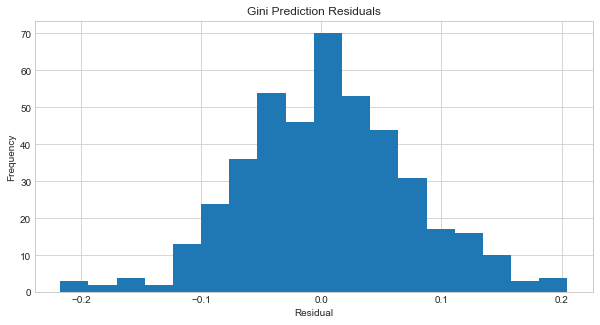

In [550]:
plt.figure(figsize=(10,5))
plt.hist(gini_pred_df['diff'], bins=18)
plt.title('Gini Prediction Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

In [551]:
print np.mean(gini_pred_df['diff'])
print np.var(gini_pred_df['diff'])**(0.5)

0.00517893921699
0.0698024349951


In [553]:
print np.mean([abs(r) for r in gini_pred_df['diff']])
print np.mean([r**2 for r in gini_pred_df['diff']])

0.0545127723494
0.00489920134265


In [507]:
print np.percentile(gini_pred_df['diff'], 2.5)
print np.percentile(gini_pred_df['diff'], 97.5)

-0.124689830795
0.146544206455


In [411]:
np.corrcoef(gini_pred, gini_true)

array([[ 1.       ,  0.2687504],
       [ 0.2687504,  1.       ]])

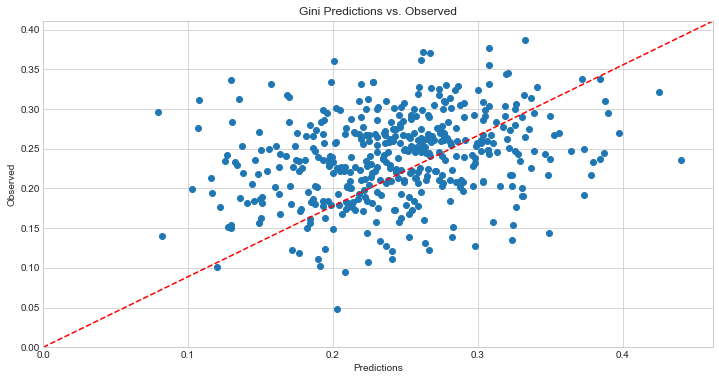

In [547]:
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(12,6))

plt.scatter(gini_pred, gini_true)
plt.title('Gini Predictions vs. Observed')
plt.xlabel('Predictions')
plt.ylabel('Observed')
plt.xlim(0)
plt.ylim(0)
plt.plot(plt.xlim(), plt.ylim(), ls="--", c="r")
plt.legend()
plt.show()

In [476]:
gini_predictions = pd.read_excel('data/gini_predictions.xlsx')

In [477]:
gini_predictions.head()

,diff,gini_pred,gini_true,team,yr
0,-0.039613,0.284677,0.324289,ATL,2003
1,0.104279,0.425140,0.320861,BOS,2003
2,-0.098335,0.150124,0.248459,CHI,2003
3,0.014513,0.274467,0.259953,CLE,2003
4,-0.019261,0.281782,0.301044,DAL,2003


In [508]:
gini_predictions.sort_values(['diff'])

,diff,gini_pred,gini_true,team,yr
294,-0.217338,0.079232,0.296570,HOU,2013
158,-0.206229,0.130057,0.336286,NOH,2008
342,-0.204383,0.107500,0.311883,WAS,2014
83,-0.177488,0.135322,0.312810,WAS,2005
206,-0.174015,0.157586,0.331601,GSW,2010
331,-0.169540,0.106765,0.276305,MIN,2014
101,-0.158860,0.200985,0.359845,NJN,2006
388,-0.153427,0.130529,0.283956,MIL,2016
228,-0.149279,0.168456,0.317735,BOS,2011
148,-0.145502,0.169861,0.315363,GSW,2008


In [485]:
yrs = range(2003,2018)
cors = []
for yr in yrs:
    gini_preds_mini = gini_predictions[gini_predictions['yr'] == yr]
    cor = np.corrcoef(gini_preds_mini['gini_pred'], gini_preds_mini['gini_true'])[0][1]
    cors.append(cor)
    print yr, cor

2003 0.346345290797
2004 -0.0346393456362
2005 0.124706192641
2006 0.330192712483
2007 0.0934274154667
2008 0.0754628086634
2009 -0.0504483399567
2010 0.279335664354
2011 0.36316888998
2012 0.142782507902
2013 0.440062011572
2014 0.161031839654
2015 0.236804554699
2016 0.193969479388
2017 0.657382053361


0.657382053361 2017


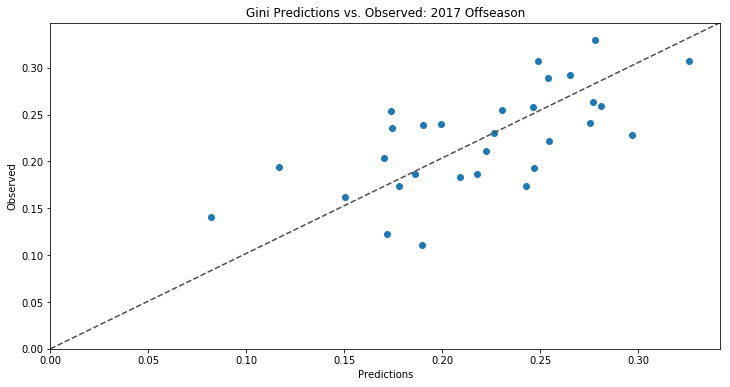

In [544]:
yr = 2017
gini_preds_mini = gini_predictions[gini_predictions['yr'] == yr]
cor = np.corrcoef(gini_preds_mini['gini_pred'], gini_preds_mini['gini_true'])[0][1]
print cor, yr

plt.figure(figsize=(12,6))
plt.title('Gini Predictions vs. Observed: 2017 Offseason')
plt.xlabel('Predictions')
plt.ylabel('Observed')

plt.scatter(gini_preds_mini['gini_pred'], gini_preds_mini['gini_true'])
plt.xlim(0)
plt.ylim(0)
plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
plt.show()

In [486]:
num_signs = []
for yr in yrs:
    signing_df = pd.read_excel('data/free_agent_signings/free_agent_signings_' + str(yr) + '.xlsx')
    print yr, len(signing_df)
    num_signs.append(len(signing_df))

2003 64
2004 80
2005 83
2006 67
2007 44
2008 50
2009 55
2010 55
2011 84
2012 60
2013 90
2014 74
2015 97
2016 94
2017 118


In [487]:
np.corrcoef(cors, num_signs)

array([[ 1.        ,  0.59830099],
       [ 0.59830099,  1.        ]])

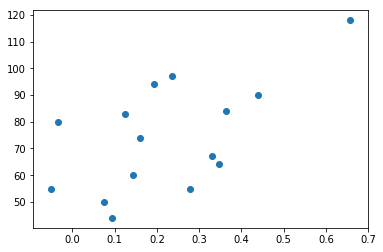

In [545]:
plt.scatter(cors, num_signs)
plt.show()

In [457]:
gini_preds_mini = gini_predictions.iloc[210:]

In [479]:
gini_preds_mini = gini_predictions.iloc[210:]
np.corrcoef(gini_preds_mini['gini_pred'], gini_preds_mini['gini_true'])[0][1]

0.33342680683414666

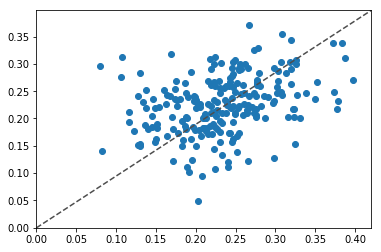

In [459]:
plt.scatter(gini_preds_mini['gini_pred'], gini_preds_mini['gini_true'])
plt.xlim(0)
plt.ylim(0)
plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
plt.show()

In [474]:
gini_preds_mini = gini_predictions.iloc[-30:]
np.corrcoef(gini_preds_mini['gini_pred'], gini_preds_mini['gini_true'])

array([[ 1.        ,  0.65738205],
       [ 0.65738205,  1.        ]])

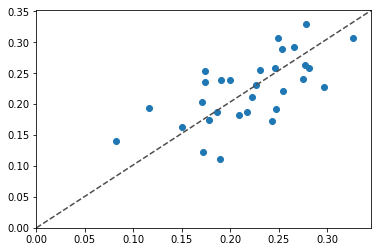

In [475]:
plt.scatter(gini_preds_mini['gini_pred'], gini_preds_mini['gini_true'])
plt.xlim(0)
plt.ylim(0)
plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
plt.show()

In [492]:
x = np.random.normal(np.mean(gini_predictions['gini_pred']),np.var(gini_predictions['gini_pred']),432)

In [493]:
np.corrcoef(x, gini_predictions['gini_pred'])

array([[ 1.       , -0.0473869],
       [-0.0473869,  1.       ]])

## Model delta gini

In [412]:
import scipy as sp
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import KFold
from sklearn.model_selection import train_test_split

/Users/danielalpert/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [427]:
data = pd.read_excel('data/transaction_model_data.xlsx')
data = data.where((pd.notnull(data)), None)
x = data.drop('delta_gini', axis=1)
y = data['delta_gini']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [428]:
data.head()

,I1,I2,I3,I4,I5,I6,coming_usg_1,coming_usg_2,coming_usg_3,delta_gini,leaving_usg_1,leaving_usg_2,leaving_usg_3,team,yr
0,1,1,1,1,1,1,0.0509029,0.0073679,0.00200041,0.0645599,0.0817884,0.0310337,0.00191377,ATL,2003
1,1,1,1,1,0,0,0.00461148,None,None,-0.0419999,0.071265,0.042379,0.0154684,BOS,2003
2,1,1,0,1,1,1,0.0967351,0.0548006,0.0226483,0.0904816,0.0561745,0.0385873,None,CHI,2003
3,1,1,0,1,0,0,0.0251006,None,None,-9.24362e-05,0.0417873,0.0319832,None,CLE,2003
4,1,1,1,1,1,1,0.0871273,0.055568,0.0387097,-0.0246666,0.0371993,0.0311145,0.00111941,DAL,2003


In [435]:
#x_train[np.isnan(x_train['coming_usg_3'])]
data = pd.read_excel('data/transaction_model_data.xlsx')
data = data[(data['coming_usg_1'] == data['coming_usg_1']) & (data['leaving_usg_1'] == data['leaving_usg_1'])]
data = data.drop(['I1','I2','I3','I4','I5','I6', 'coming_usg_3', 'leaving_usg_3', 
                   'coming_usg_2', 'leaving_usg_2','yr', 'team'], axis=1)
x = data.drop('delta_gini', axis=1)
y = data['delta_gini']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [436]:
len(x_train), len(x_test)

(267, 115)

In [448]:
# Max_depth

score_sum = 0
for j in range(30):
    rf = ensemble.RandomForestRegressor(max_depth=4, max_features='sqrt')
    rf = rf.fit(x_train, y_train)
    score_sum += rf.score(x_test, y_test)

    print i, j, rf.score(x_test, y_test)
score_sum/float(30)


15 0 0.0565552971369
15 1 0.0504849035383
15 2 0.0547987875498
15 3 0.0416627224896
15 4 0.047539249836
15 5 0.01983226827
15 6 0.0672555672649
15 7 0.00589430367864
15 8 -0.00487485449911
15 9 -0.00722851871562
15 10 0.0472715845979
15 11 0.0452791734842
15 12 0.0208405654266
15 13 0.0303451647748
15 14 0.014502824319
15 15 0.0421896619146
15 16 0.046611101392
15 17 0.0312502991851
15 18 0.0086225277173
15 19 0.0229753841357
15 20 -0.0116939307001
15 21 0.0374879517938
15 22 0.0529739305206
15 23 0.0353328336994
15 24 0.0635014452295
15 25 0.0517351077181
15 26 0.0495880704098
15 27 0.00355781700799
15 28 0.0575605563767
15 29 0.0250028340042


0.033561820985227427

In [449]:
scores_depth

array([ 0.04069707,  0.03789703,  0.02832717,  0.0351616 ,  0.03152877,
        0.04938509,  0.02730792,  0.04128174,  0.03299308,  0.03775569,
        0.04029284,  0.03000803,  0.05001538,  0.03126788,  0.04096692])

In [ ]:
gini_next_year = []

for i in 
gini.append(())

In [450]:
ginis = pd.read_excel('data/nba_results_gini_new.xlsx')

In [451]:
ginis.head()

,Team,W,L,WL_pct,PW,PL,PS/G,PA/G,yr,abbr,playoffs,gini
0,Boston Celtics,53,29,0.646,48,34,108.0,105.4,2017,BOS,3,0.211476
1,Cleveland Cavaliers,51,31,0.622,49,33,110.3,107.2,2017,CLE,4,0.292304
2,Toronto Raptors,51,31,0.622,52,30,106.9,102.6,2017,TOR,2,0.258728
3,Washington Wizards,49,33,0.598,46,36,109.2,107.4,2017,WAS,2,0.329842
4,Atlanta Hawks,43,39,0.524,39,43,103.2,104.0,2017,ATL,1,0.239535


In [454]:
ginis.iloc[30]

Team        Cleveland Cavaliers
W                            57
L                            25
WL_pct                    0.695
PW                           57
PL                           25
PS/G                      104.3
PA/G                       98.3
yr                         2016
abbr                        CLE
playoffs                      5
gini                   0.240441
Name: 30, dtype: object

In [ ]:
for i in ra

In [5]:
def get_transactions(yr):
    link = 'https://www.basketball-reference.com/leagues/NBA_' + str(yr) + '_transactions.html'
    page = urllib.urlopen(link).read()
    soup = BeautifulSoup(page, "lxml")
    trade_lst = soup.find('div', {'id': 'content'})
    lis = trade_lst.find_all('li')
    transactions = []
    dates = []
    for li in lis:
        ps = li.find_all('p')
        for p in ps:
            transactions.append(p)

            date = li.span.text
            d = date.split(' ')
            month = strptime(d[0][:3],'%b').tm_mon
            dt = datetime.date(int(d[2]), int(month), int(d[1][:-1]))

            dates.append(dt)
            #transactions.append((li.span.text, p))
            
    signings = [(date, trans) for date, trans in zip(dates, transactions) if (('signed' in trans.text) & ('assigned' not in trans.text))]
    signings_off_season = [sign for sign in signings if sign[0] < datetime.date(yr,1,1)]
    
    signing_df = pd.DataFrame()
    for i, sign in enumerate(signings_off_season):
        print i
        info = get_signing_info(sign)
        signing_df = signing_df.append({
                'date': info[0],
                'player_id': info[1],
                'usg_prev': info[2],
                'team_prev': info[3],
                'team_prev_gini_before': info[4],
                'team_prev_gini_after': info[5],
                'team_to': info[6],
                'team_to_gini_before': info[7],
                'team_to_gini_after': info[8]
            }, ignore_index = True)
        
    signing_df = signing_df[pd.notnull(signing_df['team_prev'])]
    signing_df = signing_df[signing_df['team_to'] != signing_df['team_prev']]
    
    return signing_df

In [6]:
yr = 2015
link = 'https://www.basketball-reference.com/leagues/NBA_' + str(yr) + '_transactions.html'
#link = 'https://www.basketball-reference.com/boxscores/198310280NJN.html'
page = urllib.urlopen(link).read()
soup = BeautifulSoup(page, "lxml")

NameError: name 'urllib' is not defined

In [162]:
trade_lst = soup.find('div', {'id': 'content'})
lis = trade_lst.find_all('li')

In [163]:
transactions = []
dates = []
for li in lis:
    ps = li.find_all('p')
    for p in ps:
        transactions.append(p)
        
        date = li.span.text
        d = date.split(' ')
        month = strptime(d[0][:3],'%b').tm_mon
        dt = datetime.date(int(d[2]), int(month), int(d[1][:-1]))
        
        dates.append(dt)
        #transactions.append((li.span.text, p))

In [164]:
signings = [(date, trans) for date, trans in zip(dates, transactions) if (('signed' in trans.text) & ('assigned' not in trans.text))]
signings_off_season = [sign for sign in signings if sign[0] < datetime.date(yr,1,1)]

In [166]:
get_signing_info(signings_off_season[294])

IndexError: list index out of range

In [378]:
sign = signings_off_season[29]
new_team = sign[1].find_all('a')[0]['data-attr-to']
    
#shotty fix
if (new_team == 'CHO') | (new_team == 'CHA'):
    new_team = 'CHH'

yr = sign[0].year

print new_team

gini_df = pd.read_excel('data/nba_results_gini_new.xlsx')
before_gini_new = gini_df[(gini_df['abbr'] == new_team) & (gini_df['yr'] == yr)]['gini'].values[0]
after_gini_new = gini_df[(gini_df['abbr'] == new_team) & (gini_df['yr'] == yr+1)]['gini'].values[0]

link_tail = sign[1].find_all('a')[1]['href']
url_parts = link_tail.split('/')
player_id = url_parts[3].split('.')[0]
player_link = 'https://www.basketball-reference.com' + link_tail
page = urllib.urlopen(player_link).read()
soup = BeautifulSoup(page, "lxml")
id_name = 'per_game.' + str(yr)

print player_id

if soup.find('tr', {'id': id_name}) != None:    
    row = soup.find_all('tr', {'id': id_name})
    tds = row[-1].find_all('td')
    old_team = tds[1].text

    if (old_team == 'CHO') | (old_team == 'CHA'):
        old_team = 'CHH'

    print old_team    
        
    before_gini_old = gini_df[(gini_df['abbr'] == old_team) & (gini_df['yr'] == yr)]['gini'].values[0]
    after_gini_old = gini_df[(gini_df['abbr'] == old_team) & (gini_df['yr'] == yr+1)]['gini'].values[0]

    box_df = pd.read_excel('data/box_scores/box_score_' + str(yr) + '.xlsx')
    box_df = fix_dates(box_df)
    team_df = box_df[box_df['team'] == old_team]

    stats = get_stats(team_df)
    usg_lst = calculate_weighted_usg_2(stats)
    usg_dict = {k:v for k, v in usg_lst}
    player_usg_prev_season = usg_dict[player_id]

    print [sign[0], player_id, player_usg_prev_season, old_team, before_gini_old, after_gini_old, new_team, before_gini_new, after_gini_new]
else:
    print [sign[0], player_id] + [None] * 7

ORL
gordobe01
CHH
Empty DataFrame
Columns: []
Index: []


KeyError: 'fga'

In [342]:
signing_df = pd.DataFrame()
for i, sign in enumerate(signings_off_season[50:60]):
    print i
    info = get_signing_info(sign)
    signing_df = signing_df.append({
            'date': info[0],
            'player_id': info[1],
            'usg_prev': info[2],
            'team_prev': info[3],
            'team_prev_gini_before': info[4],
            'team_prev_gini_after': info[5],
            'team_to': info[6],
            'team_to_gini_before': info[7],
            'team_to_gini_after': info[8]
        }, ignore_index = True)

0
singlky01
1
greenge01
2
bassbr01
3
jerebjo01
4
ajincal01
5
holidju01
6
cunnida01
7
davisan02
8
lillada01
9
oquinky01


In [335]:
signing_df

,date,player_id,team_prev,team_prev_gini_after,team_prev_gini_before,team_to,team_to_gini_after,team_to_gini_before,usg_prev
0,2015-07-09,singlky01,OKC,0.302537,0.247236,OKC,0.302537,0.247236,0.017841
1,2015-07-09,greenge01,PHO,0.150547,0.226467,MIA,0.220041,0.265598,0.088263
2,2015-07-09,bassbr01,BOS,0.205388,0.143420,LAL,0.219770,0.094376,0.095208
3,2015-07-09,jerebjo01,BOS,0.205388,0.143420,BOS,0.205388,0.143420,0.026476
4,2015-07-09,ajincal01,NOP,0.210584,0.245616,NOP,0.210584,0.245616,0.047918
5,2015-07-09,holidju01,GSW,0.292160,0.234076,ATL,0.226271,0.201224,0.026167
6,2015-07-09,cunnida01,NOP,0.210584,0.245616,NOP,0.210584,0.245616,0.064098
7,2015-07-09,davisan02,NOP,0.210584,0.245616,NOP,0.210584,0.245616,0.152401
8,2015-07-09,lillada01,POR,0.231633,0.291359,POR,0.231633,0.291359,0.174650
9,2015-07-09,oquinky01,ORL,0.208880,0.285885,NYK,0.184487,0.157363,0.039458


In [336]:
signing_df = signing_df[pd.notnull(signing_df['team_prev'])]
signing_df = signing_df[signing_df['team_to'] != signing_df['team_prev']]

In [337]:
len(signing_df)

4

In [338]:
sign = signings_off_season[5]
sign

(datetime.date(2015, 7, 6),
 <p>The <a data-attr-to="BRK" href="/teams/BRK/2016.html">Brooklyn Nets</a> signed <a href="/players/h/holliro01.html">Rondae Hollis-Jefferson</a> to a multi-year contract.</p>)

In [293]:
get_signing_info(sign)

holliro01


[datetime.date(2015, 7, 6),
 'holliro01',
 0.026145787972729196,
 u'BRK',
 0.221699759362285,
 0.22647300242673599,
 'BRK',
 0.221699759362285,
 0.22647300242673599]

In [3]:
signing_df = get_transactions(2014)

NameError: name 'get_transactions' is not defined

In [4]:
signing_df = get_transactions(yr)

NameError: name 'get_transactions' is not defined

In [160]:
## Multiple years
df = pd.DataFrame()
for team in np.unique(signing_df['team_to']):
    usg_data = get_transaction_usgs(team)
    df = df.append({
            'leaving_usg_1': usg_data[0],
            'leaving_usg_2': usg_data[1],
            'leaving_usg_3': usg_data[2],
            'coming_usg_1': usg_data[3],
            'coming_usg_2': usg_data[4],
            'coming_usg_3': usg_data[5],
            'I1': usg_data[0] != None,
            'I2': usg_data[1] != None,
            'I3': usg_data[2] != None,
            'I4': usg_data[3] != None,
            'I5': usg_data[4] != None,
            'I6': usg_data[5] != None,
            'delta_gini': usg_data[6],
        }, ignore_index = True)

0
paytoel01
1
whittsh01
2
gordoaa01
3
mcgarmi01
4
smartma01
5
adamsjo01
6
randoza01
7
lavinza01
8
cottobr01
9
stausni01
10
parkeja01
11
harriga01
12
cabocbr01
13
lowryky01
14
sefolth01
15
irvinky01
16
farmajo01
17
hawessp01
18
kamanch01
19
blakest01
20
gortama01
21
youngja01
22
anderky01
23
livinsh01
24
aldrico01
25
wilcocj01
26
rudezda01
27
milescj01
28
hoodro01
29
gordobe01
30
exumda01
31
collida01
32
allenla01
33
haywago01
34
pattepa01
35
millspa02
36
jamesle01
37
cartevi01
38
warretj01
39
diawbo01
40
parsoch01
41
anthoca01
42
randlju01
43
mcrobjo01
44
chalmma01
45
meeksjo01
46
grangda01
47
fryech01
48
danietr01
49
bradlav01
50
wadedw01
51
telfase01
52
udrihbe01
53
augusdj01
54
butleca01
55
nowitdi01
56
smithru01
57
anderch01
58
anderal01
59
denglu01
60
ennisja01
61
jerregr01
62
johnsja01
63
morroan01
64
harride01
65
vasqugr01
66
piercpa01
67
smithja02
68
serapke01
69
smithis01
70
napiesh01
71
lewisra02
72
griffer01
73
bairsca01
74
davisgl01
75
templga01
76
gasolpa01
77
mirotni01
78

IndexError: list index out of range